In [130]:
# 定义权重、神经元、梯度
import numpy as np
weights = {}
weights_scale = 1e-2
filters = 3
fc_units=84
weights["K1"] = weights_scale * np.random.randn(1, filters, 5, 5).astype(np.float64)
weights["b1"] = np.zeros(filters).astype(np.float64)
weights["W2"] = weights_scale * np.random.randn(filters * 11 * 11, fc_units).astype(np.float64)
weights["b2"] = np.zeros(fc_units).astype(np.float64)
weights["W3"] = weights_scale * np.random.randn(fc_units, 10).astype(np.float64)
weights["b3"] = np.zeros(10).astype(np.float64)

# 初始化神经元和梯度
nuerons={}
gradients={}

In [131]:
# 定义前向传播和反向传播
from cnn.layers import fc_forward,fc_backward
from cnn.layers import flatten_forward,flatten_backward
from cnn.activations import relu_forward,relu_backward
from cnn.losses import cross_entropy_loss
from cnn.layers import _insert_zeros,_remove_padding


In [132]:
#关于卷积层和池化层的前向和反向传播

def conv_forward(z, K, b, padding=(0, 0), strides=(1, 1)):
    """
    多通道卷积前向过程
    :param z: 卷积层矩阵,形状(N,C,H,W)，N为batch_size，C为通道数
    :param K: 卷积核,形状(C,D,k1,k2), C为输入通道数，D为输出通道数
    :param b: 偏置,形状(D,)
    :param padding: padding
    :param strides: 步长
    :return: 卷积结果
    """
    padding_z = np.lib.pad(z, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), 'constant', constant_values=0)
    N, _, height, width = padding_z.shape
    C, D, k1, k2 = K.shape
    assert (height - k1) % strides[0] == 0, '步长不为1时，步长必须刚好能够被整除'
    assert (width - k2) % strides[1] == 0, '步长不为1时，步长必须刚好能够被整除'
    conv_z = np.zeros((N, D, 1 + (height - k1) // strides[0], 1 + (width - k2) // strides[1]))
    for n in np.arange(N):
        for d in np.arange(D):
            for h in np.arange(height - k1 + 1)[::strides[0]]:
                for w in np.arange(width - k2 + 1)[::strides[1]]:
                    conv_z[n, d, h // strides[0], w // strides[1]] = np.sum(padding_z[n, :, h:h + k1, w:w + k2] * K[:, d]) + b[d]
    return conv_z


def conv_backward(next_dz, K, z, padding=(0, 0), strides=(1, 1)):
    """
    多通道卷积层的反向过程
    :param next_dz: 卷积输出层的梯度,(N,D,H',W'),H',W'为卷积输出层的高度和宽度
    :param K: 当前层卷积核，(C,D,k1,k2)
    :param z: 卷积层矩阵,形状(N,C,H,W)，N为batch_size，C为通道数
    :param padding: padding
    :param strides: 步长
    :return:
    """
    N, C, H, W = z.shape
    C, D, k1, k2 = K.shape

    # 卷积核梯度
    # dK = np.zeros((C, D, k1, k2))
    padding_next_dz = _insert_zeros(next_dz, strides)

    # 卷积核高度和宽度翻转180度
    flip_K = np.flip(K, (2, 3))
    # 交换C,D为D,C；D变为输入通道数了，C变为输出通道数了
    swap_flip_K = np.swapaxes(flip_K, 0, 1)
    # 增加高度和宽度0填充
    ppadding_next_dz = np.lib.pad(padding_next_dz, ((0, 0), (0, 0), (k1 - 1, k1 - 1), (k2 - 1, k2 - 1)), 'constant', constant_values=0)
    dz = conv_forward(ppadding_next_dz.astype(np.float64), swap_flip_K.astype(np.float64), np.zeros((C,), dtype=np.float64))

    # 求卷积核的梯度dK
    swap_z = np.swapaxes(z, 0, 1)  # 变为(C,N,H,W)与
    dK = conv_forward(swap_z.astype(np.float64), padding_next_dz.astype(np.float64), np.zeros((D,), dtype=np.float64))

    # 偏置的梯度
    db = np.sum(np.sum(np.sum(next_dz, axis=-1), axis=-1), axis=0)  # 在高度、宽度上相加；批量大小上相加

    # 把padding减掉
    dz = _remove_padding(dz, padding)  # dz[:, :, padding[0]:-padding[0], padding[1]:-padding[1]]

    return dK / N, db / N, dz

def max_pooling_forward(z, pooling, strides=(2, 2), padding=(0, 0)):
    """
    最大池化前向过程
    :param z: 卷积层矩阵,形状(N,C,H,W)，N为batch_size，C为通道数
    :param pooling: 池化大小(k1,k2)
    :param strides: 步长
    :param padding: 0填充
    :return:
    """
    N, C, H, W = z.shape
    # 零填充
    padding_z = np.lib.pad(z, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), 'constant', constant_values=0)

    # 输出的高度和宽度
    out_h = (H + 2 * padding[0] - pooling[0]) // strides[0] + 1
    out_w = (W + 2 * padding[1] - pooling[1]) // strides[1] + 1

    pool_z = np.zeros((N, C, out_h, out_w))

    for n in np.arange(N):
        for c in np.arange(C):
            for i in np.arange(out_h):
                for j in np.arange(out_w):
                    pool_z[n, c, i, j] = np.max(padding_z[n, c,
                                                          strides[0] * i:strides[0] * i + pooling[0],
                                                          strides[1] * j:strides[1] * j + pooling[1]])
    return pool_z

def max_pooling_backward(next_dz, z, pooling, strides=(2, 2), padding=(0, 0)):
    """
    最大池化反向过程
    :param next_dz：损失函数关于最大池化输出的损失
    :param z: 卷积层矩阵,形状(N,C,H,W)，N为batch_size，C为通道数
    :param pooling: 池化大小(k1,k2)
    :param strides: 步长
    :param padding: 0填充
    :return:
    """
    N, C, H, W = z.shape
    _, _, out_h, out_w = next_dz.shape
    # 零填充
    padding_z = np.lib.pad(z, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), 'constant',
                           constant_values=0)
    # 零填充后的梯度
    padding_dz = np.zeros_like(padding_z)

    for n in np.arange(N):
        for c in np.arange(C):
            for i in np.arange(out_h):
                for j in np.arange(out_w):
                    # 找到最大值的那个元素坐标，将梯度传给这个坐标
                    flat_idx = np.argmax(padding_z[n, c,
                                                   strides[0] * i:strides[0] * i + pooling[0],
                                                   strides[1] * j:strides[1] * j + pooling[1]])
                    h_idx = strides[0] * i + flat_idx // pooling[1]
                    w_idx = strides[1] * j + flat_idx % pooling[1]
                    padding_dz[n, c, h_idx, w_idx] += next_dz[n, c, i, j]
    # 返回时剔除零填充
    return _remove_padding(padding_dz, padding)

In [133]:
# 定义前向传播
def forward(X):
    nuerons["conv1"]=conv_forward(X.astype(np.float64),weights["K1"],weights["b1"])
    nuerons["conv1_relu"]=relu_forward(nuerons["conv1"])
    nuerons["maxp1"]=max_pooling_forward(nuerons["conv1_relu"].astype(np.float64),pooling=(3,3))

    nuerons["flatten"]=flatten_forward(nuerons["maxp1"])
    
    nuerons["fc2"]=fc_forward(nuerons["flatten"],weights["W2"],weights["b2"])
    nuerons["fc2_relu"]=relu_forward(nuerons["fc2"])
    
    nuerons["y"]=fc_forward(nuerons["fc2_relu"],weights["W3"],weights["b3"])

    return nuerons["y"]

# 定义反向传播
def backward(X,y_true):
    loss,dy=cross_entropy_loss(nuerons["y"],y_true)
    gradients["W3"],gradients["b3"],gradients["fc2_relu"]=fc_backward(dy,weights["W3"],nuerons["fc2_relu"])
    gradients["fc2"]=relu_backward(gradients["fc2_relu"],nuerons["fc2"])
    
    gradients["W2"],gradients["b2"],gradients["flatten"]=fc_backward(gradients["fc2"],weights["W2"],nuerons["flatten"])
    
    gradients["maxp1"]=flatten_backward(gradients["flatten"],nuerons["maxp1"])
       
    gradients["conv1_relu"]=max_pooling_backward(gradients["maxp1"].astype(np.float64),nuerons["conv1_relu"].astype(np.float64),pooling=(3,3))
    gradients["conv1"]=relu_backward(gradients["conv1_relu"],nuerons["conv1"])
    gradients["K1"],gradients["b1"],_=conv_backward(gradients["conv1"],weights["K1"],X)
    return loss

In [134]:
# 获取精度
def get_accuracy(X,y_true):
    y_predict=forward(X)
    return np.mean(np.equal(np.argmax(y_predict,axis=-1),
                            np.argmax(y_true,axis=-1)))

In [135]:
from cnn.load_mnist import load_mnist_datasets
from cnn.utils import to_categorical

train_set, val_set, test_set = load_mnist_datasets('./Data/mnist.pkl.gz')
train_x,val_x,test_x=np.reshape(train_set[0],(-1,1,28,28)),np.reshape(val_set[0],(-1,1,28,28)),np.reshape(test_set[0],(-1,1,28,28))
train_y,val_y,test_y=to_categorical(train_set[1]),to_categorical(val_set[1]),to_categorical(test_set[1])

In [136]:
# 随机选择训练样本
train_num = train_x.shape[0]
def next_batch(batch_size):
    idx=np.random.choice(train_num,batch_size)
    return train_x[idx],train_y[idx]

x,y= next_batch(16)
print("x.shape:{},y.shape:{}".format(x.shape,y.shape))

x.shape:(16, 1, 28, 28),y.shape:(16, 10)


In [137]:
from cnn.optimizers import SGD
# 初始化变量
batch_size=4
steps = 2000
steps_value = []
loss_value = []

# 更新梯度
sgd=SGD(weights,lr=0.01,decay=1e-6)

for s in range(steps):
    X,y=next_batch(batch_size)

    # 前向过程
    forward(X)
    # 反向过程
    loss=backward(X,y)


    sgd.iterate(weights,gradients)

    if s % 100 ==0:
        print("\n step:{} ; loss:{}".format(s,loss))
        idx=np.random.choice(len(val_x),200)
        print(" train_acc:{};  val_acc:{}".format(get_accuracy(X,y),get_accuracy(val_x[idx],val_y[idx])))
        steps_value.append(s)
        loss_value.append(loss)
        
print("\n final result test_acc:{};  val_acc:{}".
      format(get_accuracy(test_x,test_y),get_accuracy(val_x,val_y)))


 step:0 ; loss:2.3022247589036335
 train_acc:0.5;  val_acc:0.07

 step:100 ; loss:2.2472242955067494
 train_acc:0.25;  val_acc:0.095

 step:200 ; loss:2.298976034665938
 train_acc:0.25;  val_acc:0.135

 step:300 ; loss:0.8733604112712567
 train_acc:0.75;  val_acc:0.405

 step:400 ; loss:0.146272261504585
 train_acc:1.0;  val_acc:0.675

 step:500 ; loss:0.5435292979427265
 train_acc:0.75;  val_acc:0.635

 step:600 ; loss:0.03229363804983079
 train_acc:1.0;  val_acc:0.855

 step:700 ; loss:1.1436215304332809
 train_acc:0.75;  val_acc:0.83

 step:800 ; loss:1.6290061515709877
 train_acc:0.5;  val_acc:0.855

 step:900 ; loss:0.3796294617902956
 train_acc:1.0;  val_acc:0.925

 step:1000 ; loss:0.14681157119511248
 train_acc:1.0;  val_acc:0.925

 step:1100 ; loss:0.023066239658705325
 train_acc:1.0;  val_acc:0.905

 step:1200 ; loss:0.0011071188071947143
 train_acc:1.0;  val_acc:0.905

 step:1300 ; loss:0.36828038778662175
 train_acc:1.0;  val_acc:0.895

 step:1400 ; loss:0.0898849763470374

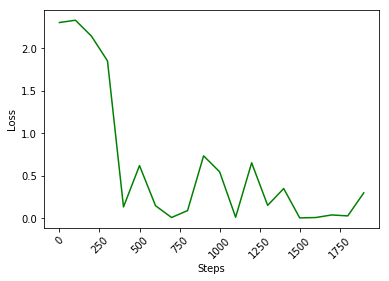

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(steps_value, loss_value,color='green')
plt.xticks(rotation=45)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

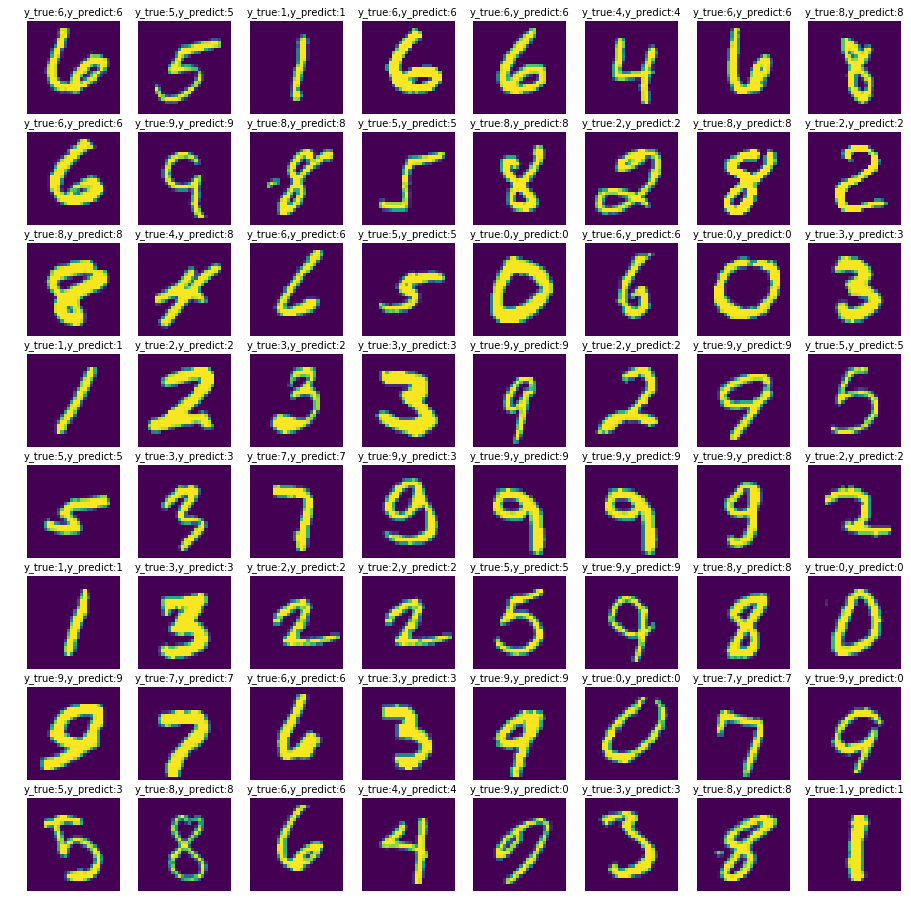

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(8, 8, figsize=(16, 16))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()

idx=np.random.choice(test_x.shape[0],64)
x,y=test_x[idx],test_y[idx]
y_predict = forward(x)
for i in np.arange(64):
    axs[i].axis('off')
    axs[i].set_title("y_true:{},y_predict:{}".format(np.argmax(y[i]),np.argmax(y_predict[i])), fontsize=10)
    axs[i].imshow(np.reshape(x[i],(28,28)))